In [1]:
#import libraries 
import pandas as pd
import numpy as np


In [2]:
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

# Pretty display for notebooks
%matplotlib inline

import seaborn as sns

In [3]:
pd.options.display.max_columns = None

In [4]:
#set variables
trading_days_to_expiration = 8
current_price = 10415
straddle_price = 965
downside_risk = 950
upside_potential = 11000

In [5]:
#function to read and format csv file 
#input: file
#output: df without NaNs, proper format

def read_format(file):
    df = pd.read_csv(file, header=0, parse_dates=True)
    #df = df.drop(df.tail(2).index)
    #df['Open Interest'].fillna(method='ffill', inplace=True)
    
    
    return df

In [6]:
# set files to a variable
file_one = r"C:\Users\Matt\Desktop\data\subject_data.csv"

In [7]:
# read in and clean csv files to a data frame 
eur = read_format(file_one)

In [8]:
eur.tail()

,Date Time,Open,High,Low,Close,Change,Volume
809,2/10/2020,9742.78,10186.32,9663.01,9865.20,122.42,40326
810,2/11/2020,9865.20,10345.26,9714.74,10234.34,369.14,46855
811,2/12/2020,10234.35,10474.59,10213.92,10381.52,147.18,60309
812,2/13/2020,10381.52,10499.36,10086.25,10182.03,-199.49,60700
813,2/14/2020,10184.26,10333.90,10103.74,10254.37,72.34,26637


In [9]:
len(eur)

814

In [10]:
days_to_train = 88

In [11]:
new_df = eur.iloc[-days_to_train:].copy()

In [12]:
new_df.head()

,Date Time,Open,High,Low,Close,Change,Volume
726,10/16/2019,8154.07,8184.12,7935.69,7994.73,-158.89,33404
727,10/17/2019,7994.74,8135.05,7948.98,8055.67,60.94,22213
728,10/18/2019,8053.18,8124.74,7849.62,7953.39,-102.28,27679
729,10/21/2019,7953.25,8356.03,7897.08,8210.56,257.17,25219
730,10/22/2019,8210.56,8315.97,8096.17,8135.08,-75.48,21558


In [13]:
'''
    Objective:  sample a dataframe for the historical volatility, find the mean over the iterations and probability 
                that vol is greater than a certain vol over that period.  
    INPUT:
    dataframe: the dataframe to sample from
    iterations: how many iterations
    range_btw_dates: range of dates to sample in consecutive order
    
    straddle_to_compare: straddle to calculate what percentage of the iterations were greater 
    lost_threshold: straddle of stop loss to calculate what percentage of the iterations were greater, 
    the downside stop loss percentage
    profit_objective: straddle of objective profit to calculate what percentage of the iterations were greater, 
    the upside, profit taking
    
    OUTPUT:
    Return the list of sample means, print a variety of statistics around the sample means.  
'''

def option_calc_group_days(df, iterations, range_btw_dates, straddle_to_compare,
                           lost_threshold, profit_objective, current_price, replace = True):
    x = 0
    moves = []
    max_index = len(df) - range_btw_dates
    while x < iterations:
        #sample a row
        the_sample = df.sample()
        #grab the index number
        the_sample_index = df.index.get_loc(the_sample.iloc[0].name)
        
        #ensure the_start_index does not run off the table
        if the_sample_index < range_btw_dates:
            the_start_index = np.abs(the_sample_index - range_btw_dates)
        else:
            the_start_index = the_sample_index - range_btw_dates
            
            
        #create the range distance between start of index and btwn_the_dates  
        plus_the_index = the_start_index + range_btw_dates
        
        the_new_df = df[the_start_index:plus_the_index]
        start_price = the_new_df.head(1)['Close'].iloc[0]
        end_price = the_new_df.tail(1)['Close'].iloc[0]
        
        #calculate the move and multiply by two for straddle price
        
        the_move = ((np.abs(start_price - end_price)) / start_price)
        
        the_move = (current_price * (the_move + 1)) - current_price
        
        moves.append(the_move)
    
        x = x + 1 
    mean = np.mean(moves)
    median = np.median(moves)
    
    mean = round(mean, 5)
    per_above_vol = round((len([i for i in moves if i > straddle_to_compare]) )/iterations, 4)
    
    per_above_lost_threshold = round((len([i for i in moves if i > lost_threshold]) )/iterations, 4)
    
    per_above_profit_objective = round((len([i for i in moves if i > profit_objective]) )/iterations, 4)
    
    
    min_move = round(min(moves), 5)
    max_move = round(max(moves), 5)
    
    
    
    
    print('The date range includes',len(df), 'days')
    print(range_btw_dates, 'day time periods were sampled')
    print('The straddle price as per the mean move is:', mean)
    print('The straddle price as per the median move is:', median)
    print('The max straddle in the sample was:', max_move)
    print('The min straddle in the sample was:', min_move)
    print('The percentage of sample groups that had mean straddles above', straddle_to_compare , 'is:',
          per_above_vol)
    print('The percentage of sample groups that had mean straddles above', lost_threshold , 'is:',
          per_above_lost_threshold)
    print('The percentage of sample groups that had mean straddles above', profit_objective , 'is:',
          per_above_profit_objective)
    
    
    return moves
    
    


In [14]:
the_list = option_calc_group_days(new_df, 10000, trading_days_to_expiration, 
                                  straddle_price, downside_risk, upside_potential, 
                                  current_price,  replace = True)

The date range includes 88 days
8 day time periods were sampled
The straddle price as per the mean move is: 863.93844
The straddle price as per the median move is: 792.4034900619445
The max straddle in the sample was: 2767.65946
The min straddle in the sample was: 3.23284
The percentage of sample groups that had mean straddles above 965 is: 0.3677
The percentage of sample groups that had mean straddles above 950 is: 0.3677
The percentage of sample groups that had mean straddles above 11000 is: 0.0


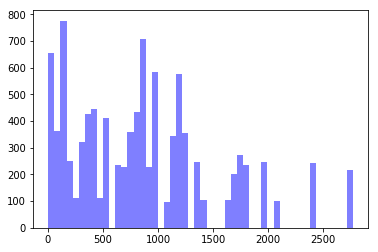

In [15]:
num_bins = 50
x = the_list
n, bins, patches = plt.hist(x, num_bins, facecolor='blue', alpha=0.5)
plt.show()

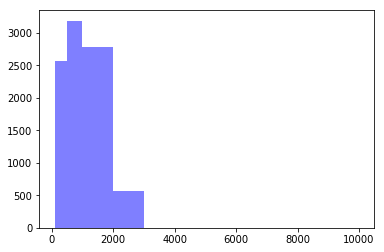

In [16]:
num_bins = 50
x = the_list
n, bins, patches = plt.hist(x, bins = [100, 500, 1000, 2000, 3000, 4000, 8000, 10000], facecolor='blue', alpha=0.5)
plt.show()

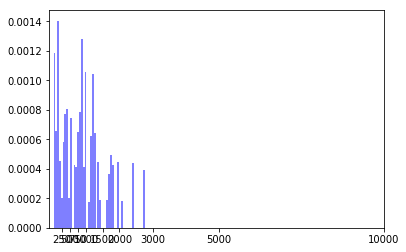

In [17]:
num_bins = 50
t = [250, 500, 750, 1000, 1500, 2000, 3000, 5000, 10000]
x = the_list
n, bins, patches = plt.hist(x, bins = 50, 
                            density = True, facecolor='blue', alpha=0.5)
plt.xticks(t)
plt.rcParams['figure.figsize'] = (20,20)
plt.show()

In [18]:
#create function that only returns the list of moves 

def moves_list(df, iterations, range_btw_dates, current_price, replace = True):
    x = 0
    moves = []
    max_index = len(df) - range_btw_dates
    while x < iterations:
        #sample a row
        the_sample = df.sample()
        #grab the index number
        the_sample_index = df.index.get_loc(the_sample.iloc[0].name)
        
        #ensure the_start_index does not run off the table
        if the_sample_index < range_btw_dates:
            the_start_index = np.abs(the_sample_index - range_btw_dates)
        else:
            the_start_index = the_sample_index - range_btw_dates
            
            
        #create the range distance between start of index and btwn_the_dates  
        plus_the_index = the_start_index + range_btw_dates
        
        the_new_df = df[the_start_index:plus_the_index]
        start_price = the_new_df.head(1)['Close'].iloc[0]
        end_price = the_new_df.tail(1)['Close'].iloc[0]
        
        #calculate the move and multiply by two for straddle price
        
        the_move = ((np.abs(start_price - end_price)) / start_price)
        
        the_move = (current_price * (the_move + 1)) - current_price
        
        moves.append(the_move)
    
        x = x + 1 
    
    
    return moves

In [19]:
#create function that takes a variety of different periods of time to train and compares
def straddle_for_many_range_of_days(df, min_days, max_days, iterations, step, current_price, days):
    x = min_days
    dict_of_straddles = {}
    while x <= max_days:
        days_in_sample_set = x
        train_df = df.iloc[-days_in_sample_set:].copy()
        #use moves_list to create the list of moves
        list_of_moves = moves_list(train_df, iterations, days, current_price)
        mean_of_moves = np.mean(list_of_moves)
        dict_of_straddles[x] = round(mean_of_moves, 4)
        
        x = x + step
        
    return dict_of_straddles  
        
        
        

In [20]:
bitcoin_straddles = straddle_for_many_range_of_days(eur, 50, 600, 10000, 50, current_price, 
                                                    trading_days_to_expiration)
bitcoin_straddles

{50: 633.3025,
 100: 703.1393,
 150: 830.9085,
 200: 898.1064,
 250: 949.3723,
 300: 879.517,
 350: 889.9942,
 400: 861.4742,
 450: 898.5855,
 500: 924.639,
 550: 984.6193,
 600: 1047.8795}

In [21]:
from statistics import mean
round(mean(bitcoin_straddles[k] for k in bitcoin_straddles), 4)

875.1281

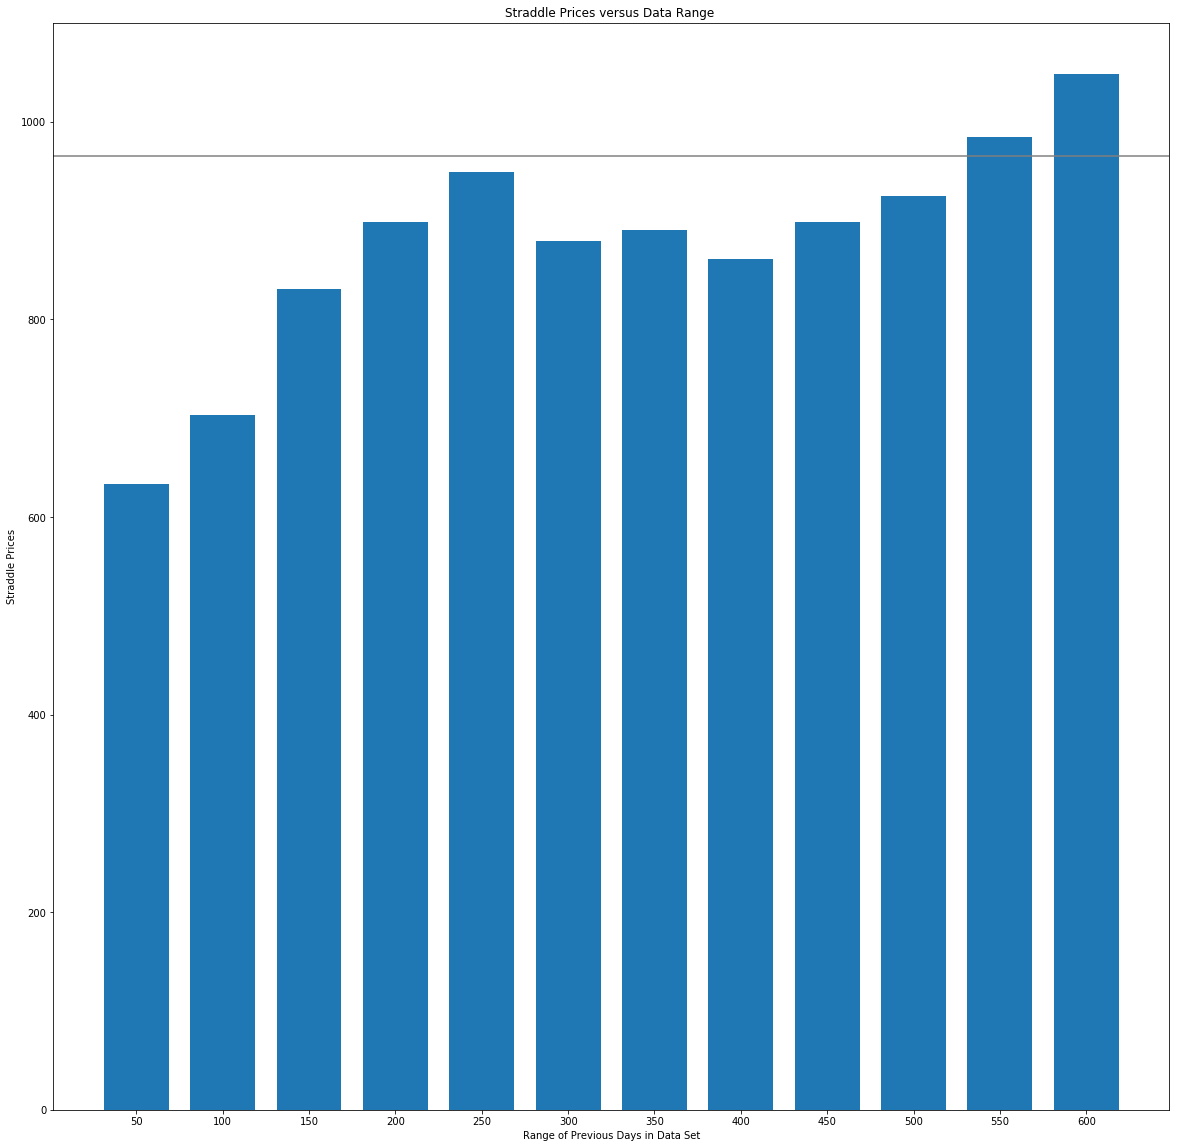

In [22]:
import pylab as pl
import numpy as np

straddle = straddle_price
d = bitcoin_straddles
X = np.arange(len(d))
pl.bar(X, d.values(), align='center', width=0.75)
pl.xticks(X, d.keys())
#ymax = max(d.values()) + 1
#pl.ylim(0, ymax)


pl.title('Straddle Prices versus Data Range ')
pl.xlabel('Range of Previous Days in Data Set')
pl.ylabel('Straddle Prices')
pl.axhline(straddle, color="gray")
#pl.figure(figsize=(3,4))
pl.show()